In [1]:
import math
import matplotlib.pyplot as plt
import numpy as np
import random

import lsst.geom
from lsst import sphgeom
from lsst.daf.butler import Butler

from lsst.dax.apdb.cassandra.partitioner import Partitioner
from lsst.dax.apdb.cassandra import ApdbCassandraConfig, ApdbCassandraPartitioningConfig
from lsst.l1dbproto import geom

from plot_regions import padded_region, plot_polygons_3d

%matplotlib widget

In [2]:
def envelope_pixels(envelope):
    count = 0
    for r1, r2 in envelope:
        count += r2 - r1 + 1
    return count

def pixel_counts(pixelator, regions):
    el = []
    for region in regions:
        envelope = pixelator.envelope(region, 0)
        el.append(envelope_pixels(envelope))
    return el

def pixel_sizes(pixelator, regions):
    sizes = []
    for region in regions:
        envelope = pixelator.envelope(region, 0)
        for pix1, pix2 in envelope:
            for pix in range(pix1, pix2+1):
                pix_region = pixelator.pixel(pix)
                circle = pix_region.getBoundingCircle()
                sizes.append(circle.getOpeningAngle().asDegrees())
    return sizes

def poly_size(convex_polygon):
    vertices = convex_polygon.getVertices()
    d1 = (vertices[1] - vertices[0]).getNorm() * 180 / math.pi
    d2 = (vertices[1] - vertices[2]).getNorm() * 180 / math.pi
    return (d1 + d2) / 2

def make_histos(counts, title):
    fig = plt.figure(figsize=(12, 8))
    fig.suptitle(title)
    axes = fig.subplots(2, 2)
    for i, (_, key) in enumerate(pixelators):
        ax = axes[i // 2][i % 2]
        ax.hist(counts[key])
        ax.set_title(key)

In [3]:
butler_config = "embargo"
butler = Butler.from_config(butler_config)

In [4]:
instrument = "LSSTCam"
days_obs = [20250701]  # or list(range(20250610, 20250631)) + [20250701]

detectors = set()
for day_obs in days_obs:
    detectors.update(
        record.id for record in butler.query_dimension_records(
            "detector", instrument=instrument, where=f"day_obs = {day_obs}", explain=False, limit=None
        )
        if record.purpose == "SCIENCE"
    )

records = []
for day_obs in days_obs:
    records += [
        record for record in butler.query_dimension_records(
            "visit_detector_region", instrument=instrument, where=f"day_obs = {day_obs}", explain=False, limit=None
        )
        if record.detector in detectors
    ]
records = random.sample(records, 200)
pp_regions = [padded_region(vdr.region, 20.) for vdr in records]

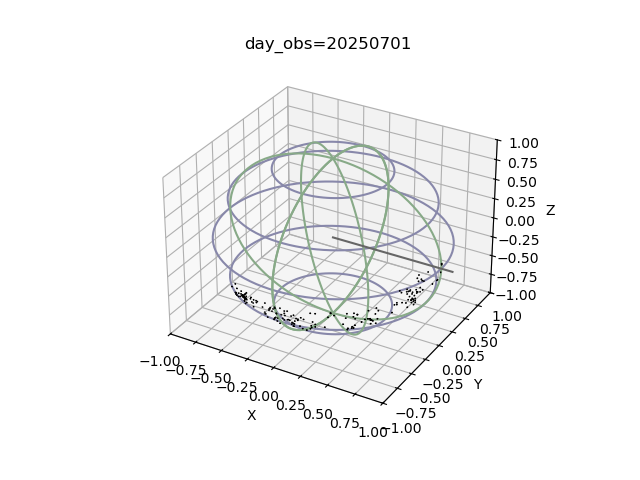

In [5]:
plot_polygons_3d(20250701, pp_regions);

In [6]:
tiles = []
tile_padding = 52
for vdr in records:
    center = vdr.region.getCentroid()
    direction = np.array([center.x(), center.y(), center.z()])
    tiles.extend(tile[2] for tile in geom.make_tiles(3.52 / 180. * math.pi, -3, direction=direction))
padded_tiles = [padded_region(tile, tile_padding) for tile in random.sample(tiles, 1000)]

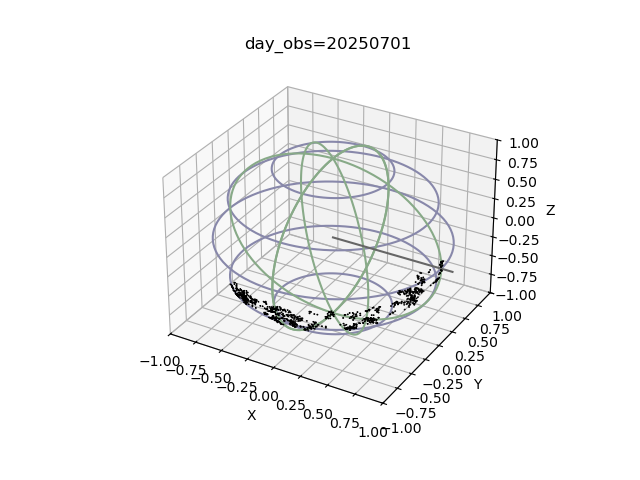

In [7]:
plot_polygons_3d(20250701, padded_tiles);

In [8]:
pixelators = [
    (sphgeom.Mq3cPixelization(10), "MQ3C:10"),
    (sphgeom.Mq3cPixelization(11), "MQ3C:11"),
    (sphgeom.HealpixPixelization(10), "HEALPIX:10"),
    (sphgeom.HealpixPixelization(11), "HEALPIX:11"),
]

In [9]:
counts_tiles = {}
for pixelator, key in pixelators:
    counts_tiles[key] = pixel_counts(pixelator, padded_tiles)

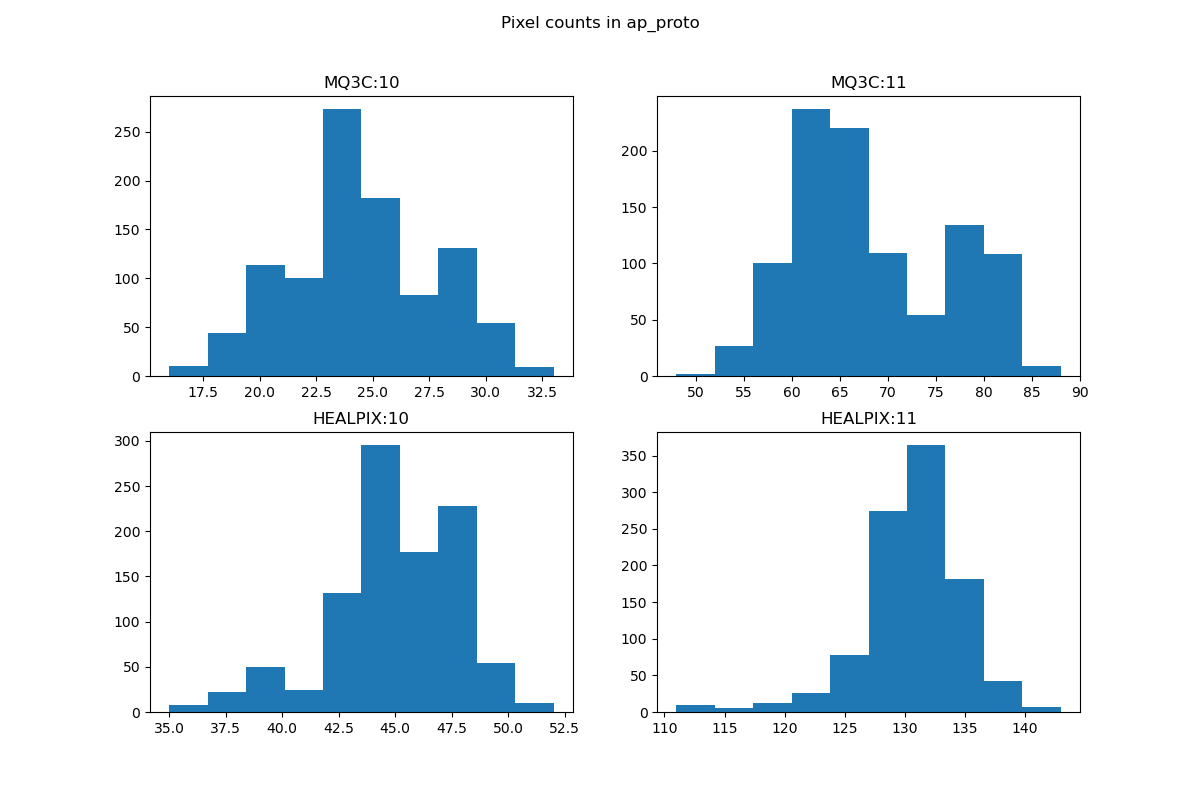

In [10]:
make_histos(counts_tiles, "Pixel counts in ap_proto")

In [11]:
counts_pp = {}
for pixelator, key in pixelators:
    counts_pp[key] = pixel_counts(pixelator, pp_regions)

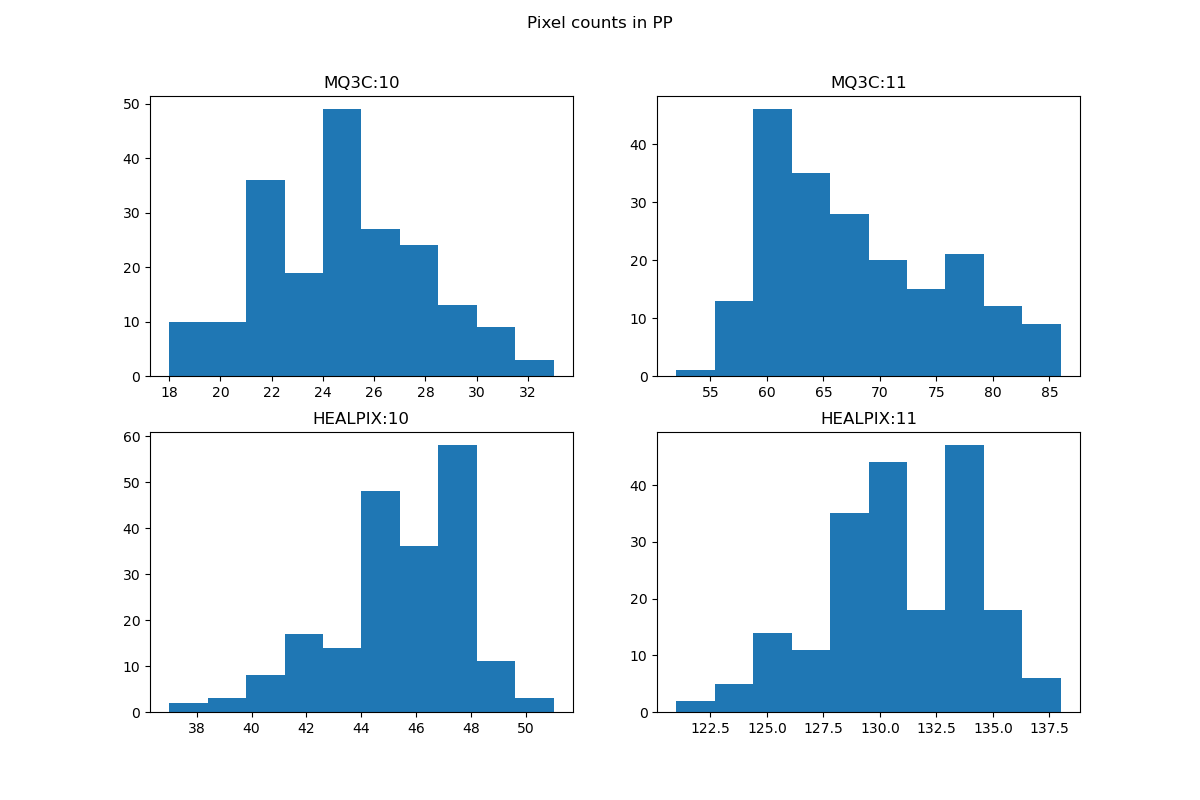

In [12]:
make_histos(counts_pp, "Pixel counts in PP")

In [13]:
sizes_tiles = {}
for pixelator, key in pixelators:
    sizes_tiles[key] = pixel_sizes(pixelator, padded_tiles)

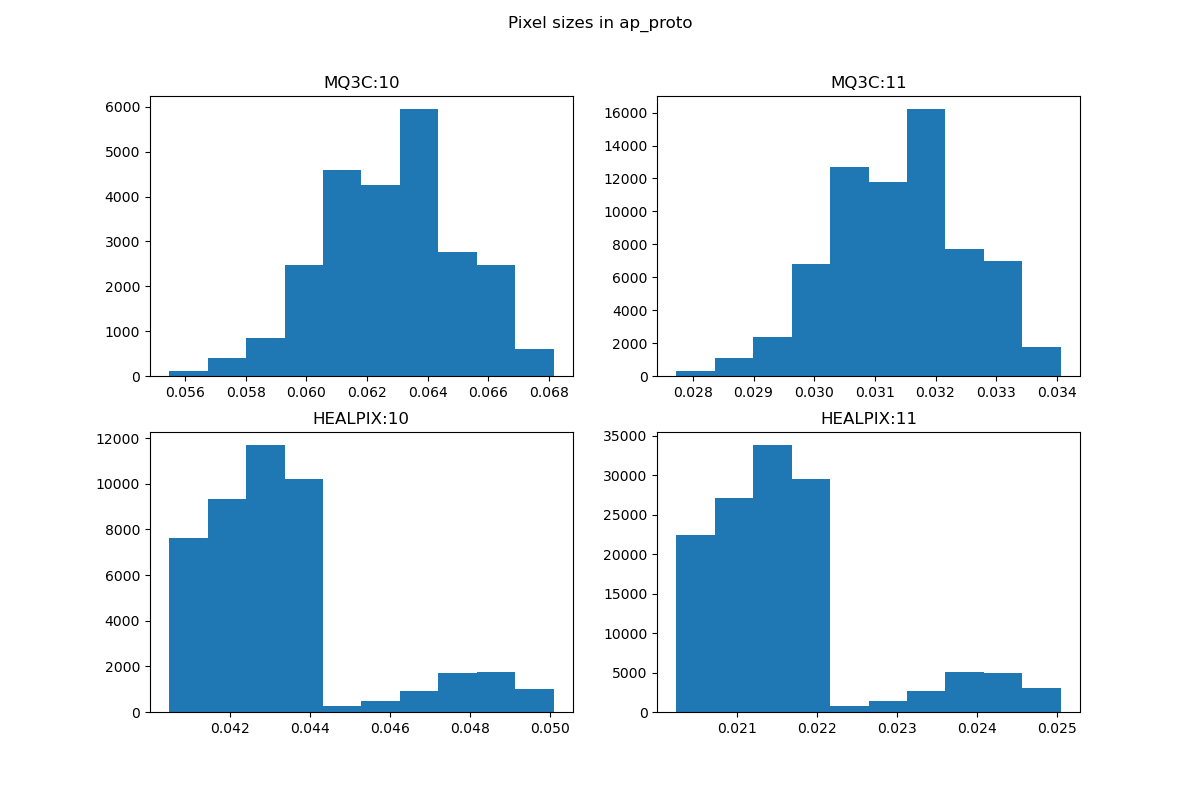

In [14]:
make_histos(sizes_tiles, "Pixel sizes in ap_proto")

In [15]:
sizes_pp = {}
for pixelator, key in pixelators:
    sizes_pp[key] = pixel_sizes(pixelator, pp_regions)

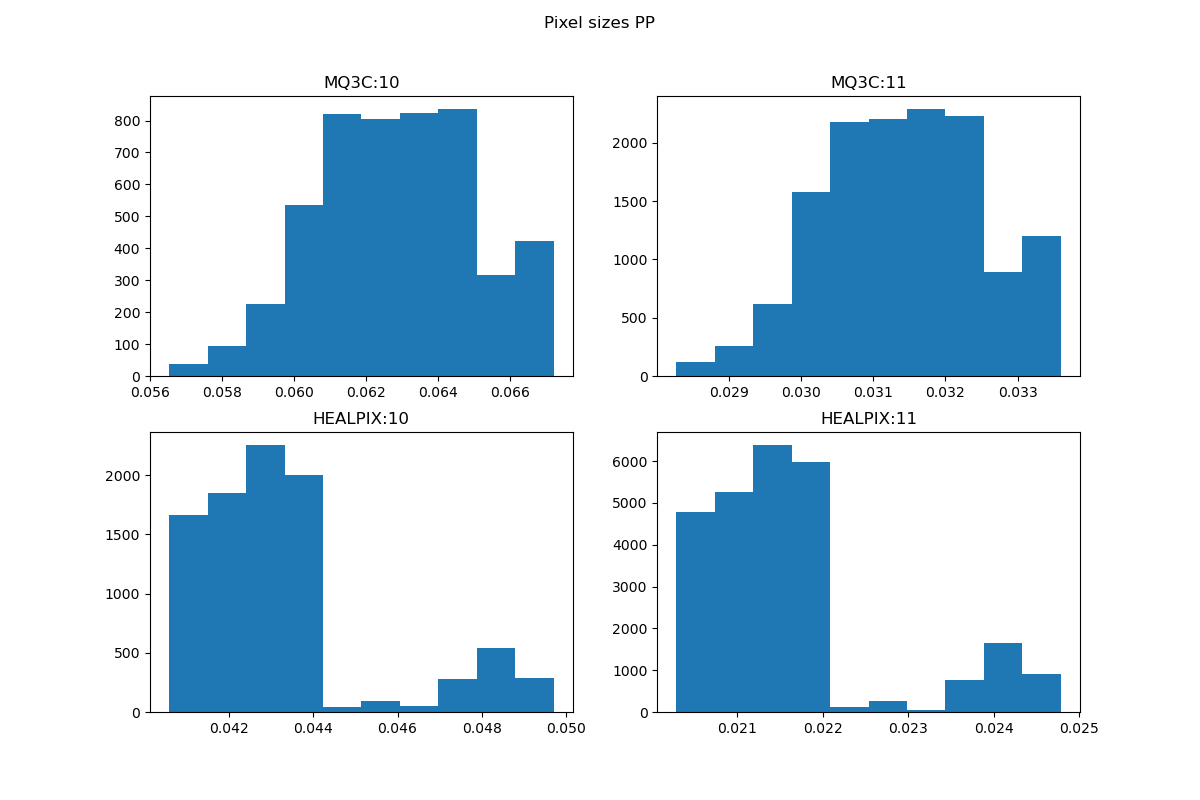

In [16]:
make_histos(sizes_pp, "Pixel sizes PP")

In [17]:
dr_size_tiles = [poly_size(tile) for tile in padded_tiles]
dr_size_pp = [poly_size(region) for region in pp_regions]

Text(0.5, 1.0, 'Detector size in PP')

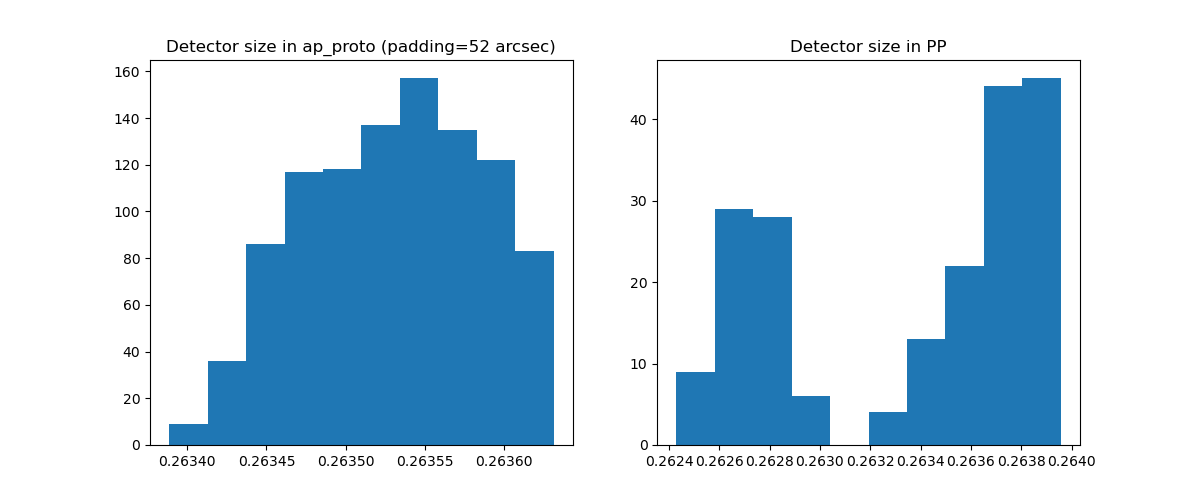

In [18]:
fig = plt.figure(figsize=(12, 5))
axes = fig.subplots(1, 2)
axes[0].hist(dr_size_tiles)
axes[0].set_title(f"Detector size in ap_proto (padding={tile_padding} arcsec)")
axes[1].hist(dr_size_pp)
axes[1].set_title("Detector size in PP")